# AutoCodificadores Variacionais (VAE)
## Este notebook aborda o treinamento de um VAE no conjunto de dados FashionMNIST.

### Nas seções a seguir, iremos:

* Explorar o conjunto de dados FashionMNIST

* Implementar uma camada de amostragem personalizada

* Implementar os modelos codificador/decodificador usando as APIs Funcionais

* Implementar funções de perda

* Sobrescrever o método train_step do modelo Keras

* Treinar o modelo VAE

* Explorar os resultados

In [1]:
import tensorflow as tf
import os
import random
import numpy as np

Vamos também definir uma semente aleatória consistente para ajudar a tornar os resultados deste notebook mais consistentes.

In [2]:
SEED = 123456
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

### Importando o dataset

In [3]:
from tensorflow.keras.datasets import fashion_mnist


(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

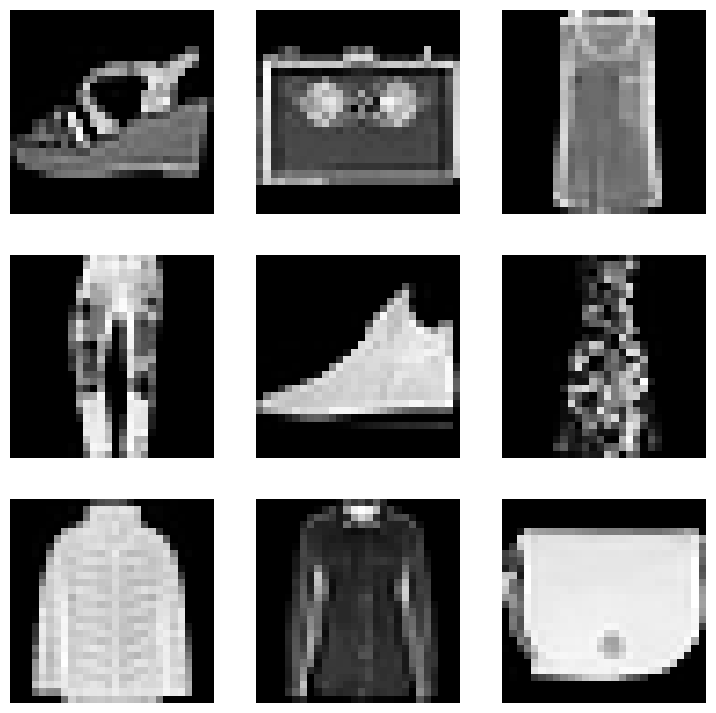

In [4]:
import numpy as np
from matplotlib import pyplot as plt

plt.figure(figsize=(9, 9))

rndSamples = np.random.choice(60000, 9)

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[rndSamples[i]], cmap="Greys_r")
    plt.axis('off')

plt.show()

* Precisamos pré-processar os dados um pouco antes que eles estejam adequados para uso com modelagem generativa. 
* Primeiro, vamos combinar nossos dados de treino e teste porque modelos generativos não funcionam com base em treino/teste medindo acurácia de classificação — eles medem o quão semelhantes as imagens geradas são em relação às originais, usando métodos de percepção visual como FID/IS (Frechet Inception Distance e Inception Score). Então, na verdade, só precisamos de um grande conjunto de imagens.
* Também precisamos normalizar os dados; os pixels brutos estão no intervalo de 0 a 255, mas os valores da ativação sigmoid estão entre 0 e 1, então vamos escalar todos os pixels para o intervalo de 0 a 1 apenas dividindo por 255.
* Além disso, precisamos adicionar uma dimensão extra, já que as camadas convolucionais esperam 3 canais.

In [5]:
dataset = np.concatenate([x_train, x_test], axis=0)
# Please note expand_dims converts images from 28x28 to 28x28x1
# Since convolutional layers expect 3 channels
dataset = np.expand_dims(dataset, -1).astype("float32") / 255

## Camada de Amostragem Personalizada ##

Nosso codificador está tentando aprender uma distribuição de probabilidade **z** dado os dados **X**. A distribuição é definida por **Mu** e **Sigma**.

Em seguida, o decodificador realiza uma amostragem aleatória a partir da distribuição **z**.

O problema é que a amostragem aleatória não é diferenciável, o que é necessário para o treinamento com backpropagation. Mas, ao introduzir um parâmetro **Épsilon**, tornamos essa operação determinística e diferenciável.

In [6]:
from tensorflow import keras
from tensorflow.keras import layers


# Create a sampling layer
class SamplingLayer(layers.Layer):
  """Reparameterization Trick z = mu + sigma * epsilon"""

  def call(self, inputs):
    zMean, zLogVar = inputs
    batch = tf.shape(zMean)[0]
    dim = tf.shape(zMean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return zMean + tf.exp(0.5 * zLogVar) * epsilon

## Codificador / Decodificador ##

Nosso codificador utiliza a API funcional do Keras para criar um modelo não sequencial, pois precisamos gerar dois valores em paralelo (média e variância).

In [7]:
def buildEncoder(latentDim, encoderInputs):

  # Dado um lote de imagens, o bloco convolucional extrai as características
  l1 = keras.models.Sequential([
    layers.Conv2D(128, 3, activation="relu", strides=2, padding="same"),
    layers.Conv2D(64, 3, activation="relu", strides=2, padding="same"),
    layers.Flatten(),
    layers.Dense(256, activation="relu")
  ])

  # passa as entradas pelo bloco convolucional
  x = l1(encoderInputs)

  # uma camada dedicada para aprender a média em paralelo
  zMean = layers.Dense(latentDim, name="z_mean")(x)

  # uma camada dedicada para aprender a variância em paralelo
  zLogVar = layers.Dense(latentDim, name="z_log_var")(x)

  # agora o truque de reparametrização para encontrar z, conforme definido pela média e variância
  z = SamplingLayer()([zMean, zLogVar])

  # o modelo real que recebe as imagens como entrada e retorna a média, variância e distribuição
  # observe que zMean e zLogVar não são a saída final do codificador, mas
  # elas são usadas na Perda de Divergência de Kullback-Leibler (explicada abaixo)
  return keras.Model(encoderInputs, [zMean, zLogVar, z], name="encoder")


# aciona a função para realmente construir o modelo
encoderInputs = keras.Input(shape=(28, 28, 1))
encoder = buildEncoder(2, encoderInputs)
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 256)          878144      ['input_1[0][0]']                
                                                                                                  
 z_mean (Dense)                 (None, 2)            514         ['sequential[0][0]']             
                                                                                                  
 z_log_var (Dense)              (None, 2)            514         ['sequential[0][0]']             
                                                                                            

In [8]:
def buildDecoder(latentInputs):

  l1 = keras.models.Sequential([
    layers.Dense(7*7*64, activation="relu", input_shape=(latentInputs.shape[1],)),
    layers.Reshape((7,7,64)),
    layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same"),
    layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same"),
    layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")
  ])

  return keras.Model(latentInputs, l1(latentInputs), name="decoder")

# build the actual model
latentInputs = keras.Input(shape=(2,))
decoder = buildDecoder(latentInputs)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 sequential_1 (Sequential)   (None, 28, 28, 1)         157633    
                                                                 
Total params: 157,633
Trainable params: 157,633
Non-trainable params: 0
_________________________________________________________________


* E agora implementaremos o decodificador de maneira semelhante. Observe o uso de Conv2DTranspose em vez de Conv2D; usamos a convolução transposta para gerar imagens, indo de resoluções mais baixas para resoluções mais altas. Esse é o verdadeiro coração dessa técnica.

## Loss Functions ##

In [9]:
def reconstructionLoss(data, reconstructed):
  return tf.reduce_mean(
      tf.reduce_sum(
          keras.losses.binary_crossentropy(data, reconstructed),
          axis=(1, 2)
      )
  )

A função de perda da Divergência de Kullback-Leibler (KL) mede a diferença entre duas distribuições de probabilidade. No contexto de redes neurais, ela compara a distribuição de probabilidade aprendida pelo modelo com a distribuição original dos dados. Se houver diferença, a função penaliza o modelo. Essa perda é semelhante à entropia cruzada, que é usada para ajustar os parâmetros do modelo durante a retropropagação, ajudando a minimizar a log-verossimilhança e melhorar a precisão do modelo.

In [10]:
def klDivergenceLoss(zMean, zLogVar):
  return tf.reduce_mean(
      tf.reduce_sum(
          -0.5 * (1 + zLogVar - tf.square(zMean) - tf.exp(zLogVar)),
          axis=1
      )
  )

Agora, vamos combinar isso na função de perda total, que simplesmente os pondera e os soma. Pense nesse peso (alpha) como outro hiperparâmetro que você pode ajustar.

In [11]:
def calcTotalLoss(data, reconstructed, zMean, zLogVar):
  loss1 = reconstructionLoss(data, reconstructed)
  loss2 = klDivergenceLoss(zMean, zLogVar)
  klWeight = 3.0
  return  loss1, loss2, loss1 + klWeight * loss2

## Sobrescrevendo o train_step ##

Como estamos usando uma função de perda personalizada para mu e sigma, precisamos sobrescrever a forma como a perda é calculada. Precisamos comparar X_original e X_reconstructed ao mesmo tempo enquanto calculamos a perda de Kullback-Leibler (KL).

In [12]:
import time

class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    # Registra a perda total como uma métrica observável no histórico de treinamento do modelo
    self.totalLossTracker = keras.metrics.Mean(name="total_loss")
    self.ceLossTracker = keras.metrics.Mean(name="ce_loss")
    self.klLossTracker = keras.metrics.Mean(name="kl_loss")
    # Métrica para tempo de treinamento
    self.timeTracker = keras.metrics.Mean(name="training_time")

  # Estas são todas as métricas observáveis
  @property
  def metrics(self):
    return [
        self.totalLossTracker,
        self.ceLossTracker,
        self.klLossTracker,
        self.timeTracker  # Métrica para o tempo de treinamento
    ]

  # Agora calcula a perda + calcula os gradientes + atualiza os pesos
  def train_step(self, data):
    start_time = time.time()  # Registra o tempo de início do treinamento

    # O Gradient Tape é uma gravação de todos os gradientes para os pesos treináveis 
    # que precisam ser atualizados
    with tf.GradientTape() as tape:
        # Caminho para frente
        zMean, zLogVar, z = self.encoder(data)
        reconstruction = self.decoder(z)
        ceLoss, klLoss, totalLoss = calcTotalLoss(data, reconstruction, zMean, zLogVar)

    # Caminho para trás
    grads = tape.gradient(totalLoss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    # Mantém o controle da perda
    self.totalLossTracker.update_state(totalLoss)
    self.ceLossTracker.update_state(ceLoss)
    self.klLossTracker.update_state(klLoss)

    # Calcula o tempo total de execução para essa etapa de treinamento
    end_time = time.time()
    training_time = end_time - start_time
    self.timeTracker.update_state(training_time)

    # Retorna a perda para o objeto de histórico
    return {
        "total_loss": self.totalLossTracker.result(),
        "ce_loss": self.ceLossTracker.result(),
        "kl_loss": self.klLossTracker.result(),
        "training_time": self.timeTracker.result()  # Adiciona o tempo de treinamento no retorno
    }


## Treinamento do VAE ##

In [13]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
history = vae.fit(dataset, epochs=32, batch_size=128)

Epoch 1/32
547/547 [==============================] - 141s 255ms/step - total_loss: 311.5787 - ce_loss: 300.1008 - kl_loss: 3.8260 - training_time: 0.2256
Epoch 2/32
547/547 [==============================] - 135s 247ms/step - total_loss: 277.9837 - ce_loss: 264.2314 - kl_loss: 4.5841 - training_time: 0.2256
Epoch 3/32
547/547 [==============================] - 138s 252ms/step - total_loss: 274.8918 - ce_loss: 260.8474 - kl_loss: 4.6814 - training_time: 0.2256
Epoch 4/32
547/547 [==============================] - 129s 236ms/step - total_loss: 273.3421 - ce_loss: 259.0193 - kl_loss: 4.7742 - training_time: 0.2256
Epoch 5/32
547/547 [==============================] - 122s 222ms/step - total_loss: 272.3755 - ce_loss: 257.8971 - kl_loss: 4.8262 - training_time: 0.2256
Epoch 6/32
547/547 [==============================] - 113s 207ms/step - total_loss: 271.3728 - ce_loss: 256.7422 - kl_loss: 4.8768 - training_time: 0.2256
Epoch 7/32
547/547 [==============================] - 103s 189ms/step 

Vamos visualizar como as funções de perda mudaram a cada época; isso pode indicar o momento em que faz sentido parar.

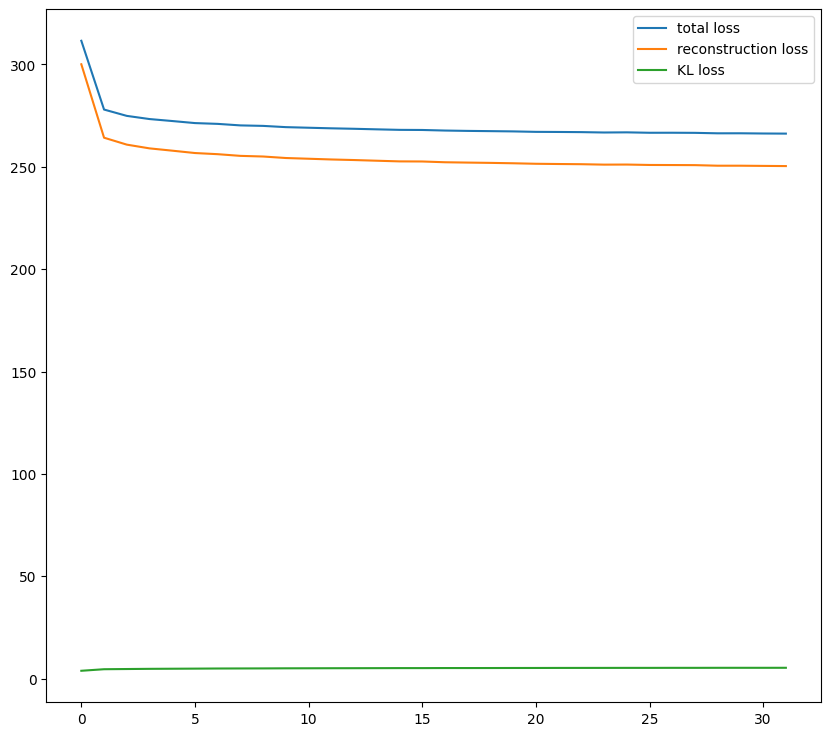

In [14]:
plt.figure(figsize=(10, 9))
plt.plot(history.history.get('total_loss'), label="total loss")
plt.plot(history.history.get('ce_loss'), label="reconstruction loss")
plt.plot(history.history.get('kl_loss'), label="KL loss")
plt.legend();

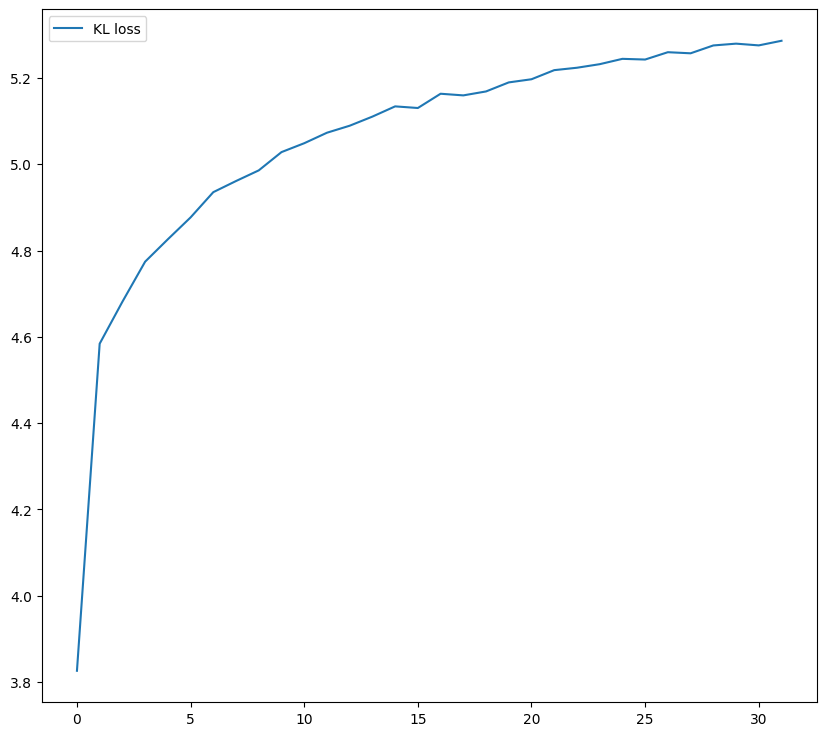

In [15]:
plt.figure(figsize=(10, 9))
plt.plot(history.history.get('kl_loss'), label="KL loss")
plt.legend();

## Explorando os Resultados ##

1/1 [==============================] - 0s 109ms/step


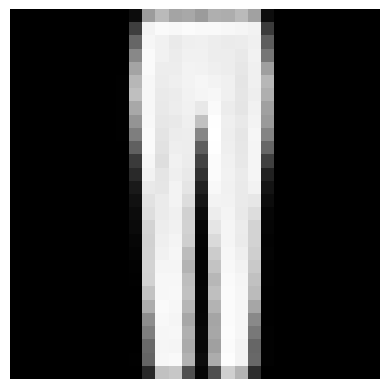

In [16]:
synth = vae.decoder.predict([[1, 2]])
plt.axis('off')
plt.imshow(synth.reshape((28,28)), cmap="Greys_r");

Vamos gerar 256 imagens totalmente aleatórias. Tudo o que precisamos fazer é adivinhar a distribuição Z (definida por mu, sigma)

8/8 [==============================] - 0s 14ms/step


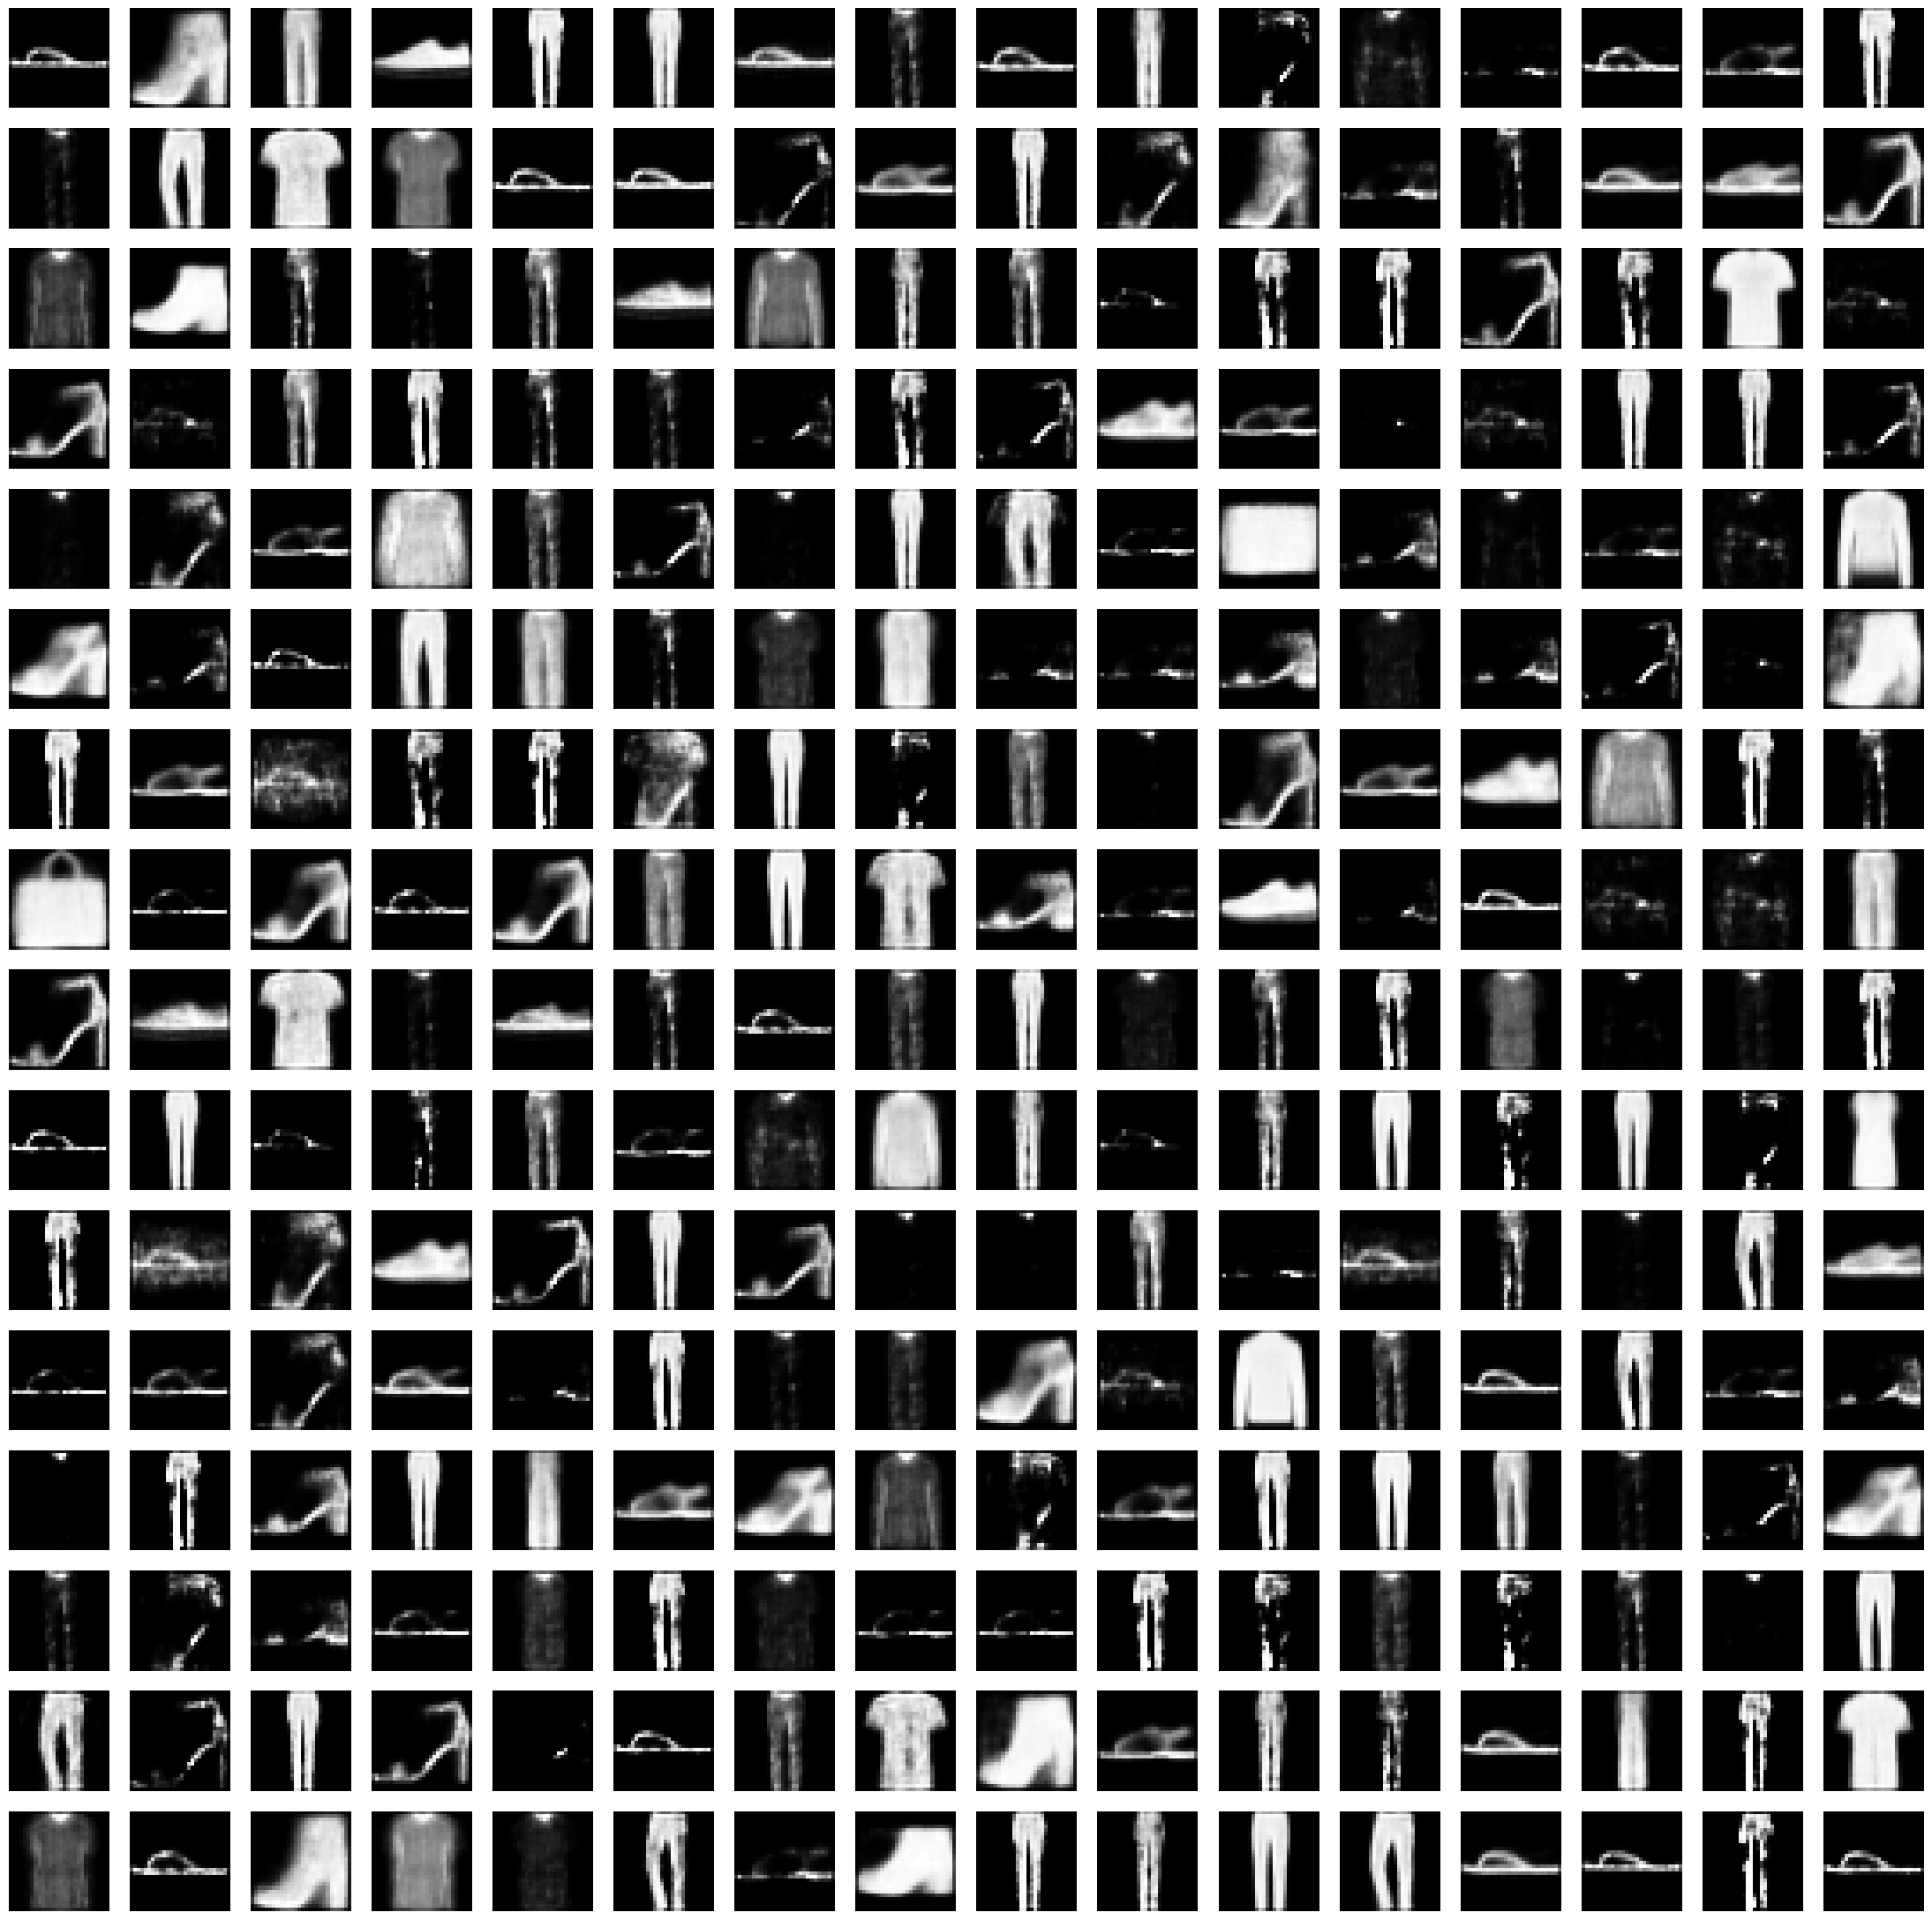

In [17]:
z = np.random.normal(loc=0, scale=4, size=(256,2))
synth = vae.decoder.predict(z)

plt.figure(figsize=(28,28))

for i in range(256):
    plt.subplot(16,16,i+1)
    plt.imshow(synth[i].reshape((28,28)), cmap="Greys_r")
    plt.axis('off')

plt.show();

* Podemos encontrar o mapeamento de mu e sigma para cada categoria. 
* Basta passar uma imagem de cada categoria pelo codificador e observar a saída. 
* Em seguida, use essas saídas para instruir condicionalmente o decodificador a amostrar de uma categoria específica. 
* No entanto, isso não é uma solução garantida - para resultados concretos, procure por "Autoencoders Variacionais Condicionais".

In [18]:
idx = 1280
batch = np.expand_dims(x_train[idx], axis=0)
batchOfImages = np.expand_dims(batch, axis=-1).astype("float32") / 255
print(batchOfImages.shape)
# obtain z(mu,sigma) for the given image
_, _, z = vae.encoder.predict(batchOfImages)

# now reconstruct a similar image
synth = vae.decoder.predict([z])

z

(1, 28, 28, 1)
1/1 [==============================] - 0s 72ms/step


array([[-0.06870131,  1.4155363 ]], dtype=float32)

* Observe que a imagem reconstruída pode ser diferente da original, dependendo de quanto tempo o modelo foi treinado e se ele atingiu um mínimo global.

* Um **mínimo global** é o ponto mais baixo em toda a superfície de uma função de perda (ou erro) durante o treinamento de um modelo. Quando um modelo atinge um mínimo global, isso significa que ele encontrou a melhor solução possível para os dados, ou seja, a combinação de parâmetros que resulta no menor valor possível da função de perda em todo o espaço de parâmetros.

* Em termos simples, é o ponto onde o modelo está funcionando da melhor forma possível, com o menor erro possível em relação aos dados de treinamento. Isso é desejado, mas nem sempre é fácil de alcançar, pois os algoritmos de treinamento podem ficar presos em **mínimos locais**, que são pontos mais baixos, mas não os mais baixos de toda a superfície.

2188/2188 [==============================] - 9s 4ms/step


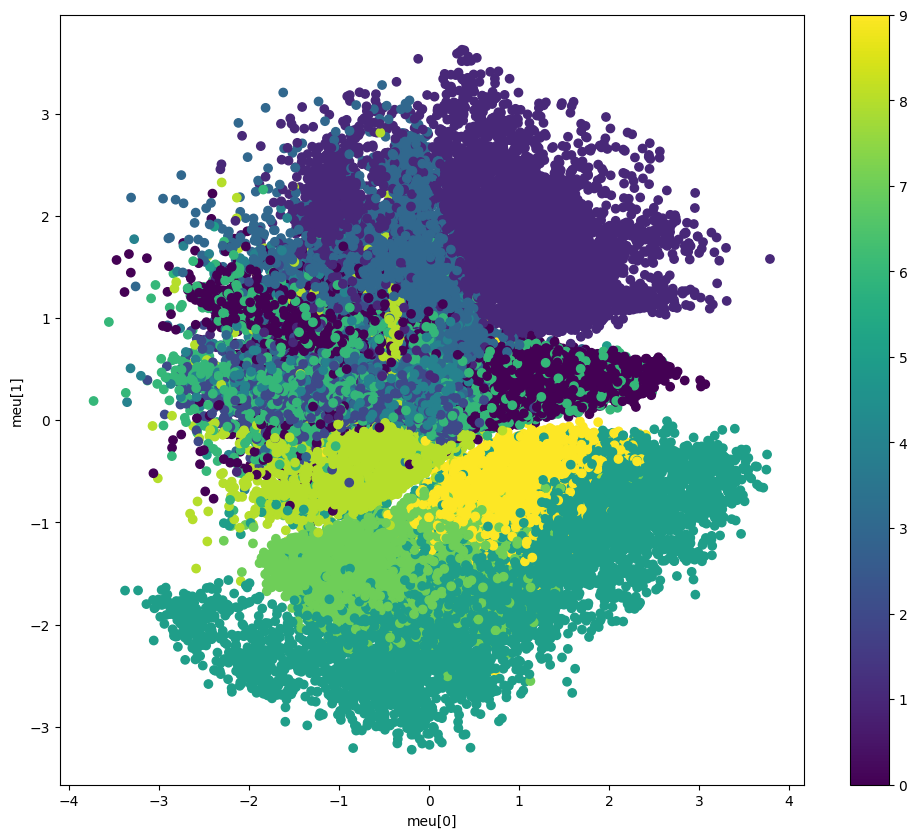

: 

In [ ]:
labels = np.concatenate([y_train, y_test], axis=0)
meu, _, _ = vae.encoder.predict(dataset)
plt.figure(figsize=(12, 10))
plt.scatter(meu[:, 0], meu[:, 1], c=labels)
plt.colorbar()
plt.xlabel("meu[0]")
plt.ylabel("meu[1]")
plt.show();

* O gráfico gerado mostra como as amostras de dados são agrupadas no espaço latente, com base em suas características aprendidas pelo modelo. Mesmo sem rótulos, o VAE tenta agrupar dados similares no espaço latente, o que pode ajudar a entender a estrutura subjacente dos dados e é útil para tarefas de clusterização.
* Essa visualização ajuda a verificar como o modelo aprende a representar dados de forma compacta e como ele agrupa dados semelhantes, sem precisar de rótulos. Essa técnica é útil em casos de aprendizado não supervisionado, onde você quer entender ou agrupar dados que não têm etiquetas predefinidas (como imagens ou textos não rotulados).